# Install the required libraries

In [ ]:
!pip install pykeen

In [ ]:
!pip install rdflib

In [ ]:
!pip install torch-geometric -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html

Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html


In [ ]:
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
import torch_geometric.nn as pyg_nn
import time
from torch_geometric.datasets import Entities
from torch_geometric.nn import FastRGCNConv, RGCNConv
from torch_geometric.utils import k_hop_subgraph
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
from rdflib import Graph, URIRef
from pykeen.triples import TriplesFactory
from collections import Counter

INFO:pykeen.utils:Using opt_einsum


In [ ]:
from pykeen.pipeline import pipeline
from pykeen.models import DistMult
from pykeen.evaluation import RankBasedEvaluator

# Download the dataset

In [ ]:
!mkdir ./data
!wget "https://www.dropbox.com/sh/ldjd70yvnu9akxi/AAAam7SBr5KXLfjk-NVGQNWRa?dl=1" -O "./data/aifb.zip"
!unzip "data/aifb.zip" -d "data/aifb"

mkdir: cannot create directory ‘./data’: File exists
--2025-10-30 04:42:47--  https://www.dropbox.com/sh/ldjd70yvnu9akxi/AAAam7SBr5KXLfjk-NVGQNWRa?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fo/5bkj2o1g1z5f5bv2x4lxj/ALDrm561FEhqGEoMe-qK3YY?rlkey=e7wqtjfh6gmqc5tpql5kkkkxp&dl=1 [following]
--2025-10-30 04:42:48--  https://www.dropbox.com/scl/fo/5bkj2o1g1z5f5bv2x4lxj/ALDrm561FEhqGEoMe-qK3YY?rlkey=e7wqtjfh6gmqc5tpql5kkkkxp&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc62fbba992a0f364eb83b335fc0.dl.dropboxusercontent.com/zip_download_get/CXkkueh1qsZTGj7zCTpcmic_Jj4hq_dWg6OcO2ps0GpiqpLEh8GIKc2ynU8Qb3V3HGAdt_6nVLzoET85jzgh3Bcdm4YAy8YXntwz24TFhjFLng# [following]
--2025-10-30 04:42:49--  https://uc6

# Another approach for training:The dataset has no X which is the input features, in this method, I am using an emdedding technique to generate embedding for each node to be used as the features vectors, and test its effect of the model performance

In [ ]:
def st(node):
    """
    Maps an rdflib node to a unique string. We use str(node) for URIs (so they can be matched to the classes) and
    we use .n3() for everything else, so that different nodes don't become unified.

    Source: https://github.com/pbloem/gated-rgcn/blob/1bde7f28af8028f468349b2d760c17d5c908b58b/kgmodels/data.py#L16
    """
    if type(node) == URIRef:
        return str(node)
    else:
        return node.n3()

g = Graph()
g.parse('/content/data/aifb/aifb_stripped.nt', format='nt')
data=[]
nodes = set()
relations = Counter()
for s, p, o in g:
        nodes.add(st(s))
        nodes.add(st(o))

        relations[st(p)] += 1

i2n = list(nodes) # maps indices to labels
n2i = {n:i for i, n in enumerate(i2n)} # maps labels to indices

for s, p, o in g:
    data.append([st(s), st(p), st(o)])
AIFB_df=pd.DataFrame(data, columns=['subject', 'predicate', 'object'])



# Assuming your dataframe has columns 'subject', 'predicate', 'object'
triples_factory = TriplesFactory.from_labeled_triples(triples=AIFB_df.values, create_inverse_triples=True)
training = triples_factory
validation = triples_factory
testing = triples_factory

d=training
id_to_entity={v: k for k, v in d.entity_to_id.items()}
id_to_relation={v: k for k, v in d.relation_to_id.items()}

# Display the first few triples
triples_factory.triples

array([['_:N01c7881cff5a4528854d3101bd1cc911',
        'http://www.w3.org/1999/02/22-rdf-syntax-ns#type',
        'http://www.w3.org/2002/07/owl#Restriction'],
       ['_:N01c7881cff5a4528854d3101bd1cc911',
        'http://www.w3.org/2002/07/owl#allValuesFrom',
        'http://swrc.ontoware.org/ontology#Publication'],
       ['_:N01c7881cff5a4528854d3101bd1cc911',
        'http://www.w3.org/2002/07/owl#onProperty',
        'http://swrc.ontoware.org/ontology#editor'],
       ...,
       ['http://www.aifb.uni-karlsruhe.de/WBS/dvr/owltools/merge/type',
        'http://www.w3.org/1999/02/22-rdf-syntax-ns#type',
        'http://www.w3.org/2002/07/owl#DatatypeProperty'],
       ['http://www.w3.org/2001/XMLSchema#string',
        'http://www.w3.org/1999/02/22-rdf-syntax-ns#type',
        'http://www.w3.org/2002/07/owl#Datatype'],
       ['http://www.w3.org/2002/07/owl#Thing',
        'http://www.w3.org/1999/02/22-rdf-syntax-ns#type',
        'http://www.w3.org/2002/07/owl#Class']], dtype='<U3

In [ ]:
result = pipeline(
    model='RotatE',
    loss="MarginRankingLoss",
    training=training,
    testing=testing,
    validation=validation,
    model_kwargs=dict(embedding_dim=64),  # Increase the embedding dimension
    optimizer_kwargs=dict(lr=0.001),  # Adjust the learning rate
    training_kwargs=dict(num_epochs=100, use_tqdm_batch=False),  # Increase the number of epochs
)
# The trained model is stored in the pipeline result
model = result.model

INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training epochs on cuda:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.


Evaluating on cuda:0:   0%|          | 0.00/29.0k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 4.34s seconds


In [ ]:
# Create an evaluator
evaluator = RankBasedEvaluator()
# Evaluate the model
metrics = evaluator.evaluate(result.model, testing.mapped_triples, additional_filter_triples=[training.mapped_triples, validation.mapped_triples])
# Print the metrics
print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")

Evaluating on cuda:0:   0%|          | 0.00/29.0k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 4.71s seconds


Hits@1: 0.7930482388183039
Hits@3: 0.8899562717350136
Hits@5: 0.9167785697069862
Hits@10: 0.9437558103501704
Mean Reciprocal Rank: 0.8492608666419983


In [ ]:
entity_emb=model.entity_representations[0]._embeddings
rel_emb=model.relation_representations[0]._embeddings

In [ ]:
entity_emb.weight[0]

tensor([-0.1002, -0.2849, -0.2638,  0.4378, -0.2413,  0.2706, -0.4637, -0.5038,
        -0.3144,  0.2923, -0.3919, -0.3303,  0.2363,  0.1490, -0.2834, -0.3113,
         0.3407,  0.4705,  0.1011,  0.4809, -0.3293,  0.3584,  0.3347, -0.3137,
         0.2268, -0.4105,  0.2949, -0.4536, -0.4095,  0.3600, -0.0320,  0.0919,
         0.3752, -0.4266, -0.3109, -0.2146, -0.3428, -0.0993,  0.4329,  0.4450,
         0.0934, -0.3799, -0.1853, -0.3700,  0.3449,  0.3507,  0.1852, -0.1205,
         0.2163,  0.3706,  0.4932, -0.2871,  0.3044,  0.0496,  0.2892, -0.4370,
         0.1751,  0.1543,  0.2107,  0.2129,  0.0317, -0.2142, -0.0077,  0.2340,
         0.4752, -0.2439,  0.2032,  0.2902,  0.3724,  0.1472,  0.4301,  0.0748,
        -0.5335, -0.0994,  0.1573,  0.0592,  0.2771, -0.4019,  0.1972,  0.2112,
        -0.0868,  0.3073,  0.3067, -0.3569, -0.4122, -0.1528, -0.2809, -0.1230,
         0.2167,  0.1645, -0.3525, -0.1462,  0.3324,  0.0367,  0.1007, -0.2685,
        -0.5463,  0.3349,  0.4278,  0.47

In [ ]:
entity_emb

Embedding(8285, 128)

In [ ]:
rel_emb

Embedding(90, 128)

In [ ]:
AIFB_RotatE_entity_emb_128_dict={ training.entity_id_to_label[i]:entity_emb.weight[i].detach().tolist() for i in range(entity_emb.weight.shape[0])}
import pickle
with open("AIFB_RotatE_entity_emb_128_dict.pkl", "wb") as file:
    pickle.dump(AIFB_RotatE_entity_emb_128_dict, file)

# Untill here, the nodes embedding have been created.
# Now, train R-gcn model on the nodes using the embeddings

In [ ]:
# Download the data, the processed version for thr entity predection task
dataset="AIFB"
#Conv = FastRGCNConv
Conv = RGCNConv
dataset = Entities('data/Entities',dataset)
data = dataset[0]

In [ ]:
data

Data(edge_index=[2, 58086], edge_type=[58086], train_idx=[140], train_y=[140], test_idx=[36], test_y=[36], num_nodes=8285)

In [ ]:
# This section is useful for large graphs; BGS and AM graphs are too big to process them in a full-batch fashion.
# Since our model does only make use of a rather small receptive field, we
# filter the graph to only contain the nodes that are at most 2-hop neighbors
# away from any training/test node.
node_idx = torch.cat([data.train_idx, data.test_idx], dim=0)
node_idx, edge_index, mapping, edge_mask = k_hop_subgraph(
    node_idx, 2, data.edge_index, relabel_nodes=True)

data.num_nodes = node_idx.size(0)
data.edge_index = edge_index
data.edge_type = data.edge_type[edge_mask]
data.train_idx = mapping[:data.train_idx.size(0)]
data.test_idx = mapping[data.train_idx.size(0):]

In [ ]:
#read the embeddings
import pickle
with open("AIFB_RotatE_entity_emb_128_dict.pkl", "rb") as file:
    AIFB_RotatE_entity_emb_128_dict=pickle.load(file)

In [ ]:
#the flag here to check whether to use embeddings
use_feat=True
if use_feat:
  data.x = torch.Tensor(data.num_nodes, len(AIFB_RotatE_entity_emb_128_dict[list(AIFB_RotatE_entity_emb_128_dict.keys())[0]]))
  torch.nn.init.xavier_uniform_(data.x)

  i2n={v: k for k, v in n2i.items()}
  count=0
  for i in range(data.num_nodes):
    # print(i)
    if i2n[i] in AIFB_RotatE_entity_emb_128_dict:
      count+=1
      data.x[i]=torch.Tensor(AIFB_RotatE_entity_emb_128_dict[i2n[i]])
else:
  data.x=None

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv( data.x.shape[1] if data.x is not None else data.num_nodes, 32, dataset.num_relations,num_bases=30)
        self.conv2 = Conv(32, dataset.num_classes, dataset.num_relations,num_bases=30)

    def forward(self,edge_index, edge_type,x=None):

        y= F.relu(self.conv1(x, edge_index, edge_type))
        y = self.conv2(y, edge_index, edge_type)
        return F.log_softmax(y, dim=1)


In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0005)

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.edge_index, data.edge_type,data.x)
    loss = F.nll_loss(out[data.train_idx], data.train_y)
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.edge_index, data.edge_type,data.x).argmax(dim=-1)
    train_acc = float((pred[data.train_idx] == data.train_y).float().mean())
    test_acc = float((pred[data.test_idx] == data.test_y).float().mean())
    return train_acc, test_acc


In [ ]:
times = []
train_loss= []
accs_train= []
accs_test= []
for epoch in range(1, 20):
    start = time.time()
    loss = train()
    train_acc, test_acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f} 'f'Test: {test_acc:.4f}')
    accs_test.append(test_acc)
    accs_train.append(train_acc)
    train_loss.append(loss)

    times.append(time.time() - start)

/tmp/ipython-input-3233952467.py:8: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  return float(loss)


Epoch: 01, Loss: 1.6846, Train: 0.6643 Test: 0.6389
Epoch: 02, Loss: 1.2853, Train: 0.8286 Test: 0.7222
Epoch: 03, Loss: 0.5547, Train: 0.9500 Test: 0.8333
Epoch: 04, Loss: 0.2195, Train: 0.9714 Test: 0.9167
Epoch: 05, Loss: 0.1510, Train: 0.9786 Test: 0.9444
Epoch: 06, Loss: 0.1410, Train: 0.9857 Test: 0.9444
Epoch: 07, Loss: 0.1144, Train: 0.9857 Test: 0.9722
Epoch: 08, Loss: 0.0858, Train: 0.9929 Test: 0.9167
Epoch: 09, Loss: 0.0655, Train: 0.9929 Test: 0.9167
Epoch: 10, Loss: 0.0489, Train: 1.0000 Test: 0.9167
Epoch: 11, Loss: 0.0360, Train: 1.0000 Test: 0.9167
Epoch: 12, Loss: 0.0269, Train: 1.0000 Test: 0.9444
Epoch: 13, Loss: 0.0207, Train: 1.0000 Test: 0.9444
Epoch: 14, Loss: 0.0164, Train: 1.0000 Test: 0.9444
Epoch: 15, Loss: 0.0134, Train: 1.0000 Test: 0.9444
Epoch: 16, Loss: 0.0112, Train: 1.0000 Test: 0.9444
Epoch: 17, Loss: 0.0091, Train: 1.0000 Test: 0.9444
Epoch: 18, Loss: 0.0074, Train: 1.0000 Test: 0.9444
Epoch: 19, Loss: 0.0058, Train: 1.0000 Test: 0.9444


In [ ]:
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Median time per epoch: 0.1739s


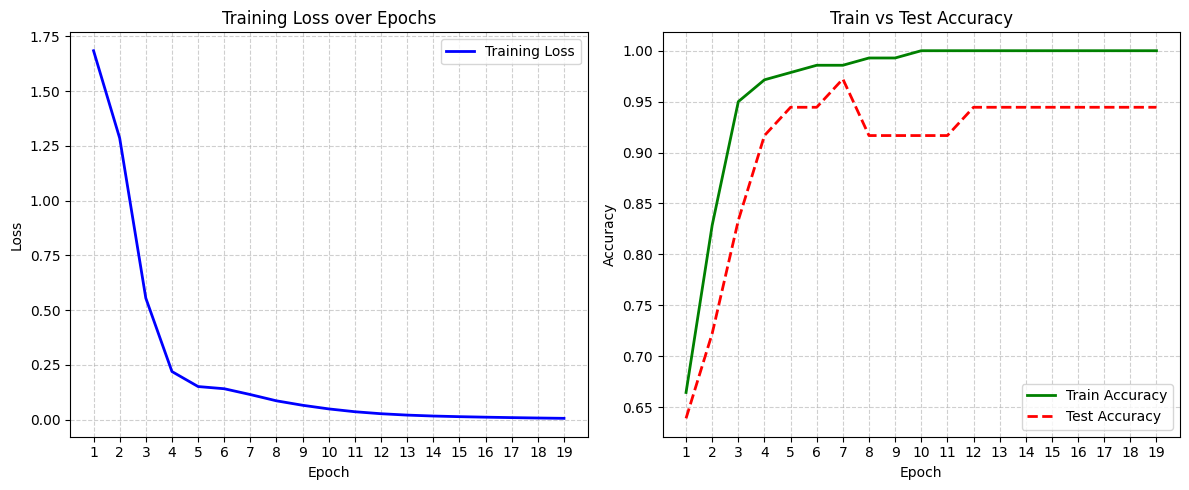

In [ ]:
epochs = np.arange(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

# --- Plot Training Loss ---
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', linewidth=2, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# --- Plot Train vs Test Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(epochs, accs_train, 'g-', linewidth=2, label='Train Accuracy')
plt.plot(epochs, accs_test, 'r--', linewidth=2, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')

plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig('Embedding-based-R-GCN training and testing results.png', dpi=300, bbox_inches='tight')
plt.show()
